# Learned Sensing Matrix

We got an encoder-decoder like system set up using a similar architecture with DeepCodec. Now let's grab the sensing matrix, load it into MATLAB, and see if we can get better results using a learned sensing matrix on MNIST!

In [39]:
import torch
from torch import nn
from glob import glob

In [40]:
ORIGINAL_SIZE = 28

In [41]:
class WFUMNISTCodec(nn.Module):
    """A NN that definitely won't work, lmao, Test our dataloader."""
    def __init__(self, original_res, sensing_res):
        """Makes a FCN type architecture, takes in picture dimension d x d"""
        super(WFUMNISTCodec, self).__init__()
        
        self.m = sensing_res
        # Sensing matrix
        self.sensing = torch.nn.Linear(original_res * original_res, sensing_res * sensing_res, bias=False)
        
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 8, kernel_size=4, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(4, 1, kernel_size=3, stride=1, padding=1)
        self.upsample = torch.nn.UpsamplingBilinear2d(size=(original_res, original_res))
        
    def forward(self, x):
        # Apply the sensing matrix without activation, reshape back to image-like for FCN
        x = self.sensing(x.view(x.shape[0], -1)).view(x.shape[0], 1, self.m, self.m)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return self.upsample(x)

In [4]:
!pwd

/home/robocup/am254


In [5]:
torchmodels = list(sorted(glob("/home/robocup/am254/models/wfunetsmall*.torchmodel")))

In [6]:
undersamplings = [int(t.replace(".torchmodel", "").split('_')[-1]) for t in torchmodels]

We want to sort by how much we are undersampling. This will make it easier to plot the undersampling ratio $\alpha$ with metrics of how well the image is recovered later.

In [11]:
torchmodels, undersamplings = zip(*list(sorted(zip(torchmodels, undersamplings), key=lambda x: x[1])))

In [14]:
print(list(undersamplings))

[4, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


## Getting the Sensing Matrix

The sensing matrix is just the first fully connected layer that maps MNIST into a lower dimensional space. Let's return this and serialize it into something that MATLAB can load.

In [15]:
def get_sensing_from_model(model):
    params = list(model.parameters())
    return params[0].detach().cpu().numpy()

In [16]:
models = [torch.load(t) for t in torchmodels]

In [17]:
sensing_layers = [get_sensing_from_model(torch.load(t)) for t in torchmodels] 

In [18]:
for sensing_matrix in sensing_layers:
    print(sensing_matrix.shape)

(16, 784)
(64, 784)
(81, 784)
(100, 784)
(121, 784)
(144, 784)
(169, 784)
(196, 784)
(225, 784)
(256, 784)
(289, 784)
(324, 784)
(361, 784)
(400, 784)
(441, 784)
(484, 784)
(529, 784)
(576, 784)
(625, 784)
(676, 784)
(729, 784)


Now let's save our results into MATLAB, so we can use these trained sensing matrices and see whether or not they can improve the results from our basis pursuit algorithm.

In [20]:
from scipy.io import savemat

In [21]:
sense_map = {}
for dim, mat in zip(undersamplings, sensing_layers):
    sense_map['sensematrix' + str(dim)] = mat
savemat('small_conv_sensing_matrices.mat', sense_map)

# Visualizing Model Results

Now let's plot the predictions for each sparsity for a very small model trained after 30 epochs.


In [22]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch import distributions as ds
from torch.utils import data as utils

import numpy as np
import scipy
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
batch_size=128, shuffle=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device: %s' % str(device))

Using device: cuda:0


In [24]:
random_test_X, random_test_y = None, None
for X, y in train_loader:
    random_test_X = X.clone()
    random_test_y = X.clone()
    break

# random_test_X, random_test_y = None, None
# for X, y in test_loader:
#     random_test_X = X.clone()
#     random_test_y = X.clone()
#     break

In [25]:
test_y_hats = [model(random_test_X.to(device)).detach() for model in models]
result_images = [test_y_hat.permute(0, 3, 1, 2).cpu().numpy().reshape(test_y_hat.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE).swapaxes(1, 2) for test_y_hat in test_y_hats]
actual = random_test_y.permute(0, 3, 1, 2).cpu().numpy().reshape(random_test_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE).swapaxes(1, 2)

/usr/local/lib/python2.7/dist-packages/torch/nn/modules/upsampling.py:225: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python2.7/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [26]:
len(result_images)

21

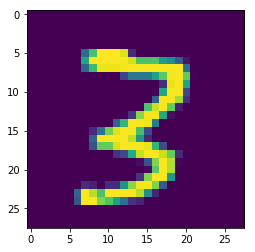

In [27]:
plt.imshow(actual[1])
plt.show()

In [28]:
import math
def snr_two_images(img1, ref):
    mse = ((img1 - ref) ** 2).mean()
    mean = (ref ** 2).mean()
    snr = 80 * math.log10(mean / np.sqrt(mse))
    return snr

The full image size of MNIST is $28 \times 28 = 784$, so the undersampling rate will be the side length squared divided by 784.

In [30]:
alphas = [u * u / 784.0 for u in undersamplings]

In [32]:
# Calculate the SNRs between predicted and actual
snrs = np.zeros((len(result_images), len(actual)))
for im_idx in range(len(actual)):
    for index in range(len(result_images)):
        snrs[index][im_idx] = snr_two_images(result_images[index][im_idx], actual[im_idx])

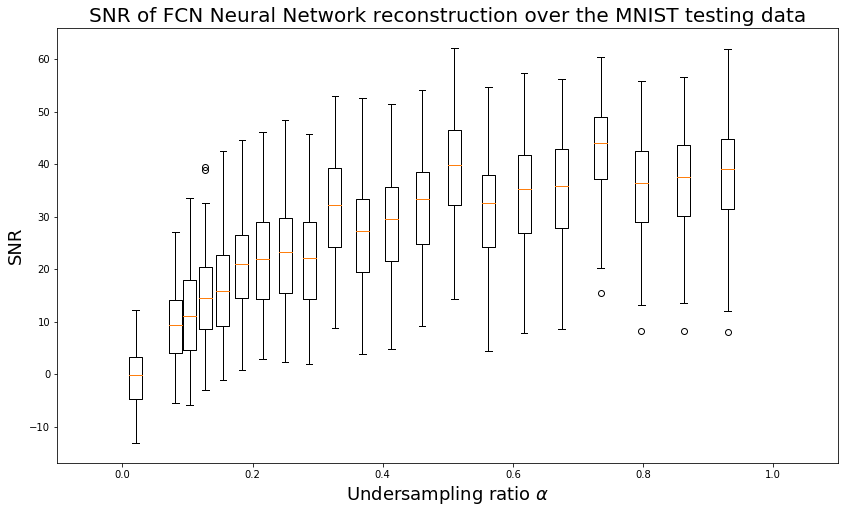

In [34]:
plt.figure(figsize=(14, 8))
plt.xlim(-0.1, 1.1)
plt.boxplot(snrs.tolist(), positions=alphas, manage_xticks=False, widths=0.02, )
plt.xlabel(r"Undersampling ratio $\alpha$", fontsize=18)
plt.ylabel(r"SNR", fontsize=18)
plt.title("SNR of FCN Neural Network reconstruction over the MNIST testing data", fontsize=20)
plt.show()

In [ ]:
def plot_examples(index_lst):
    SIZE = 3
    n_models = len(result_images)
    k = len(index_lst)
    plt.figure(figsize=(SIZE * n_models, SIZE * k))  
    print(n_models)
    for i, index in enumerate(index_lst):
        for idx, result_image in enumerate(result_images):
            # Get minimum of the result and the real image to use same colorbar colors
            # Write titles if it is the first one
            plt.subplot(k, n_models + 1, (n_models + 1) * i + 1 + idx)
            
            if i == 0:
                undersample_rate = float(undersamplings[idx] ** 2) / ORIGINAL_SIZE ** 2
                plt.title('Undersample = %0.2f' % undersample_rate, fontsize=50)
            
            res = (((result_image[index] + 0.1307)))
            # plt.imshow(res, cmap='gray', vmin=min_val, vmax=max_val)
            plt.imshow(res, cmap='gray')
            # plt.colorbar()
            plt.autoscale(False)
            #print(n_models * i + 1 + idx)

        #print(n_models * (i + 1))
        plt.subplot(k, n_models + 1, (n_models + 1) * (i + 1) + 1)
        a = ((actual[index] + 0.1307))
        # plt.imshow(a, cmap='gray', vmin=min_val, vmax=max_val)
        # plt.imshow(actual[index], cmap='gray')
        plt.imshow(actual[index], cmap='gray')
        # plt.colorbar()
        plt.autoscale(False)
        
    plt.show()

In [ ]:
plot_examples([1, 2, 3, 4])